# Solving a Multiple Knapsacks Problem

Multidimensional knapsack problems, in which the items have more than one physical quantity, such as weight and volume, and the knapsack has a capacity for each quantity. Here, the term dimension does not necessarily refer to the usual spatial dimensions of height, length, and width. However, some problems might involve spatial dimensions, for example, finding the optimal way to pack rectangular boxes into a rectangular storage bin.

This section shows how to solve the knapsack problem for multiple knapsacks using both the MIP solver and the CP-SAT solver. In this case, it's common to refer to the containers as bins, rather than knapsacks.

Hapag-Lloyd AG is a German international shipping and container transportation company. Hapag-Lloyd was formed in 1970 through a merger of Hamburg-American Line (HAPAG) and Norddeutscher Lloyd.

<div>
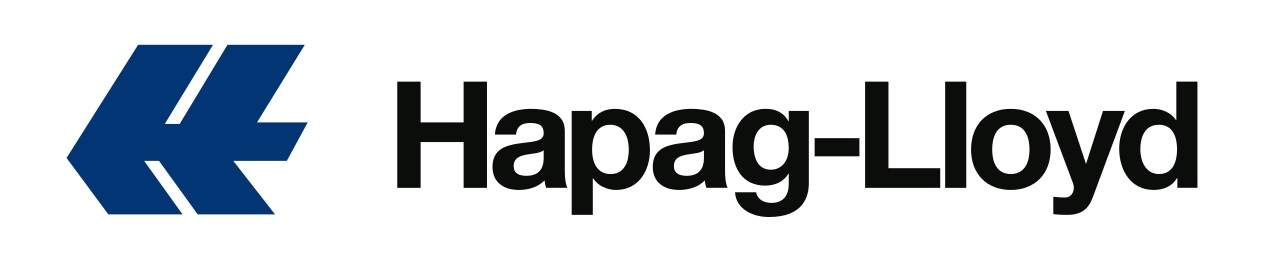
</div>

In this project, we want to pack as more as possible items in the four 20' Standard Hapag Lloyd container.

# 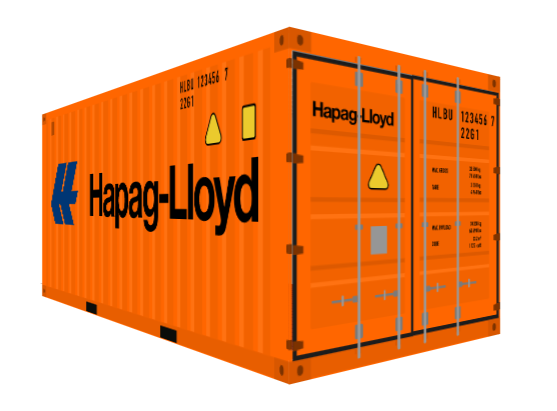

The Inside Dimension of this container is as below:
* Length: 590 cm
* Width: 235 cm
* Height: 239 cm

And the maximum capacity of it is:
* Max Gross: 30,480 kg
* Max Payload: 28,130 kg

The problem is to pack a subset of the items into five bins, each of which has a maximum capacity of 28,130 kg, so that the total packed value is a maximum.

In the knapsack problem, the "value" refers to the benefit or usefulness associated with each item that is being considered for packing into the container. The value can be measured in various ways, depending on the specific application. For example, in a business context, the value could represent the profit or revenue generated by each item. In a personal context, the value could represent the utility or enjoyment derived from each item.

Here's an example of the knapsack problem:

Suppose you are planning a hiking trip and need to pack a backpack with a maximum capacity of 15 pounds. You have a set of items to choose from, each with a given weight and value:

* Item 1: Tent, weight = 6 pounds, value = $120

* Item 2: Sleeping bag, weight = 4 pounds, value = $80

* Item 3: Water filter, weight = 1 pound, value = $40

* Item 4: Cooking stove, weight = 2 pounds, value = $60

* Item 5: Food (3-day supply), weight = 10 pounds, value = $100

You can't fit all the items in your backpack because their total weight (23 pounds) exceeds the maximum capacity. Therefore, you need to choose a subset of the items that will fit and maximize the total value.

Using a dynamic programming approach, you can solve the knapsack problem and determine the optimal subset of items to pack. The solution depends on the specific objective function and constraints of the problem.

Now, let's back to our problem:

## MIP solution

### Import the libraries

In [6]:
from ortools.linear_solver import pywraplp
import numpy as np

### Create the data

Here is the list of 19 item that we want to pack:

* Electronics - 2,268 kg - €212,175
* Clothing - 5,443 kg - €101,280
* Furniture - 3,629 kg - €127,485
* Sporting goods - 2,722 kg - €68,080
* Toys - 4,536 kg - €84,720
* Building materials - 8,165 kg - €169,560
* Automotive parts - 6,804 kg - €254,400
* Cosmetics - 1,814 kg - €84,720
* Industrial machinery - 7,711 kg - €338,880
* Personal care products - 3,629 kg - €84,720
* Medical equipment - 8,165 kg - €508,800
* Books and stationery - 5,443 kg - €33,600
* Home appliances - 6,804 kg - €127,485
* Pet supplies - 2,268 kg - €42,360
* Agricultural products - 12,000 kg - €84,720
* Artwork - 1,814 kg - €84,720
* Chemicals - 8,165 kg - €318,240
* Beauty products - 2,722 kg - €84,720
* Office supplies - 4,536 kg - €33,600

The data includes the following:

weights: A vector containing the weights of the items.
values: A vector containing the values of the items.
capacities: A vector containing the capacities of the bins.
In this example, all the bins have the same capacity, but that need not be true in general.

The data includes the following:

* weights: A vector containing the weights of the items.
* values: A vector containing the values of the items.
* capacities: A vector containing the capacities of the bins.
In this example, all the bins have the same capacity, but that need not be true in general.

In [16]:
data = {}
data['weights'] = [
    2268, 5443, 3629, 2722, 4536, 8165, 6804, 1814, 7711, 3629, 8165, 5443, 6804, 2268, 12000, 1814
    , 8165, 2722, 4536]
data['values'] = [
    212175, 101280, 127485, 68080, 84720, 169560, 254400, 84720, 338880, 84720, 508800, 33600, 127485, 42360, 84720,
    84720, 318240, 84720, 33600]
assert len(data['weights']) == len(data['values'])
data['num_items'] = len(data['weights'])
data['all_items'] = range(data['num_items'])

data['bin_capacities'] = [28130, 28130, 28130, 28130]
data['num_bins'] = len(data['bin_capacities'])
data['all_bins'] = range(data['num_bins'])

### Declare the MIP solver

In [17]:
solver = pywraplp.Solver.CreateSolver('SCIP')
if solver is None:
    print('SCIP solver unavailable.')

### Create the variables

In [18]:
# x[i, b] = 1 if item i is packed in bin b.
x = {}
for i in data['all_items']:
    for b in data['all_bins']:
        x[i, b] = solver.BoolVar(f'x_{i}_{b}')

### Define the constraints

In [19]:
# Each item is assigned to at most one bin.
for i in data['all_items']:
    solver.Add(sum(x[i, b] for b in data['all_bins']) <= 1)

# The amount packed in each bin cannot exceed its capacity.
for b in data['all_bins']:
    solver.Add(
        sum(x[i, b] * data['weights'][i]
            for i in data['all_items']) <= data['bin_capacities'][b])

### Define the objective

In [20]:
# Maximize total value of packed items.
objective = solver.Objective()
for i in data['all_items']:
    for b in data['all_bins']:
        objective.SetCoefficient(x[i, b], data['values'][i])
objective.SetMaximization()

### Invoke the solver

In [21]:
status = solver.Solve()

### Print the solution

In [23]:
if status == pywraplp.Solver.OPTIMAL:
    print(f'Total packed value: {objective.Value()} €')
    total_weight = 0
    for b in data['all_bins']:
        print(f'Bin {b}')
        bin_weight = 0
        bin_value = 0
        for i in data['all_items']:
            if x[i, b].solution_value() > 0:
                print(
                    f"Item {i} weight: {data['weights'][i]} value: {data['values'][i]}"
                )
                bin_weight += data['weights'][i]
                bin_value += data['values'][i]
        print(f'Packed bin weight: {bin_weight}')
        print(f'Packed bin value: {bin_value}\n')
        total_weight += bin_weight
    print(f'Total packed weight: {total_weight} kg')
else:
    print('The problem does not have an optimal solution.')

Total packed value: 2844265.0 €
Bin 0
Item 0 weight: 2268 value: 212175
Item 1 weight: 5443 value: 101280
Item 2 weight: 3629 value: 127485
Item 3 weight: 2722 value: 68080
Item 4 weight: 4536 value: 84720
Item 5 weight: 8165 value: 169560
Packed bin weight: 26763
Packed bin value: 763300

Bin 1
Item 6 weight: 6804 value: 254400
Item 7 weight: 1814 value: 84720
Item 8 weight: 7711 value: 338880
Item 9 weight: 3629 value: 84720
Item 10 weight: 8165 value: 508800
Packed bin weight: 28123
Packed bin value: 1271520

Bin 2
Item 11 weight: 5443 value: 33600
Item 12 weight: 6804 value: 127485
Item 13 weight: 2268 value: 42360
Item 14 weight: 12000 value: 84720
Packed bin weight: 26515
Packed bin value: 288165

Bin 3
Item 15 weight: 1814 value: 84720
Item 16 weight: 8165 value: 318240
Item 17 weight: 2722 value: 84720
Item 18 weight: 4536 value: 33600
Packed bin weight: 17237
Packed bin value: 521280

Total packed weight: 98638 kg
